In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
import matplotlib.pyplot as plt
from image_fitting_ensemble_example import create_ensemble, get_data, get_datasets

import sys
sys.path.append("../")

folder = "../test_case_4/"
save_dir = "alpha_1e-3_snapshot_lr_01"

all_k, all_images, bins, xx = get_data(folder)
train_dset, test_dset = get_datasets(all_k, all_images, save_dir)
gt_initial_beam = torch.load(folder + "ground_truth_dist.pt")

from torch_track import Beam
defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

gt_initial_beam = Beam(gt_initial_beam, **defaults)


bandwidth = torch.tensor(0.0)
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)
ensemble = ensemble
ensemble.cuda();

torch.Size([20, 1, 200, 200])
torch.Size([20, 1])
torch.Size([200])


In [2]:
bins[1] - bins[0]

tensor(0.0003)

In [3]:
train_k = train_dset.k
train_k = train_k.cuda()

train_im = train_dset.images
train_im = train_im.cpu()

test_k = test_dset.k
test_k = test_k.cuda()

test_im = test_dset.images
test_im = test_im.cpu()

In [4]:
recompute_images = True
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = dist.sample([100000]).cuda()

        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1].cuda())[0].unsqueeze(0) for i in range(len(ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()

        #torch.save(train_pred, "train_pred_images.pt")
        #torch.save(test_pred, "test_pred_images.pt")
    else:
        pass
        #train_pred = torch.load("train_pred_images.pt")
        #test_pred = torch.load("test_pred_images.pt")

In [5]:
# compare initial beam distributions
from torch_track import Beam
defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

# generate beams from model
pred_initial_beams = [ele.beam_generator() for ele in ensemble]


In [6]:
ensemble

CustomSnapshotRegressor(
  (estimators_): ModuleList(
    (0): MaxEntropyQuadScan(
      (beam_generator): InitialBeam(
        (transformer): NonparametricTransform(
          (stack): Sequential(
            (0): Linear(in_features=6, out_features=50, bias=True)
            (1): Tanh()
            (2): Linear(in_features=50, out_features=50, bias=True)
            (3): Dropout(p=0.0, inplace=False)
            (4): Tanh()
            (5): Linear(in_features=50, out_features=50, bias=True)
            (6): Dropout(p=0.0, inplace=False)
            (7): Tanh()
            (8): Linear(in_features=50, out_features=50, bias=True)
            (9): Dropout(p=0.0, inplace=False)
            (10): Tanh()
            (11): Linear(in_features=50, out_features=50, bias=True)
            (12): Dropout(p=0.0, inplace=False)
            (13): Tanh()
            (14): Linear(in_features=50, out_features=6, bias=True)
          )
        )
      )
      (lattice): QuadScanTransport(
        (quad): T

torch.Size([20, 1, 200, 200])
0.023066655419190073
0.027120635195989517
0.01756236130176388
tensor(0.0805, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.0467, device='cuda:0', grad_fn=<StdBackward0>)


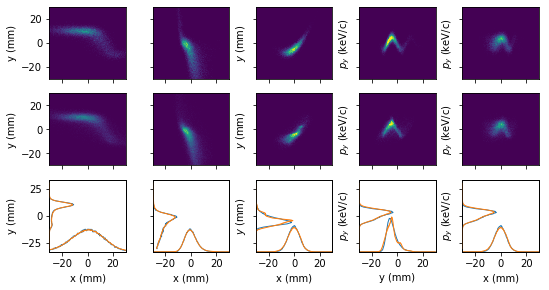

In [7]:
from visualization import add_image, add_projection, add_image_projection
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase
pairs = [["x","y"],["y","py"],["x","py"]]

fig,ax = plt.subplots(3,len(pairs)+2, sharex="col",sharey="row")
fig.subplots_adjust(wspace=0.35, right=0.975, top=0.975)
fig.set_size_inches(8,4)
    
print(all_images.shape)
plot_bins = bins
#plot_bins = plot_bins * 1e3

vmax = 0.2e5
linewidth=1.0
for g, pair in enumerate(pairs):
    i = g + 2
    
    plot_bins = [bins]*2
    scale = 1e3
    if pair == ["z","pz"]:
        plot_bins = bins*10
        scale = 1e6
    
    _, gt_image = add_image(ax[0][i], *pair, [gt_initial_beam], plot_bins,
                            scale_axis=scale,vmax=vmax)
    #print(np.max(gt_image))
    _, pred_image = add_image(ax[1][i], *pair, [pred_initial_beams[0]], plot_bins,
                           scale_axis=scale,vmax=vmax)

    # calculate rms error
    rms_error = np.sqrt(((gt_image - pred_image)**2).sum() / gt_image.size)
    print(rms_error / np.max(gt_image))

    if pair[-1]=="y":
        for a in ax[:,i]:
            a.set_ylabel("$y$ (mm)")
    elif pair[-1]=="py":
        for a in ax[:,i]:
            a.set_ylabel("$p_y$ (keV/c)")
    elif pair[-1]=="px":
        for a in ax[:,i]:
            a.set_ylabel("$p_x$ (keV/c)")

    # x projections
    max_dens = 250
    axa = ax[2][i].twinx()
    add_projection(axa, pair[0], [gt_initial_beam], plot_bins[0], x_scale=scale, y_scale=1)
    add_projection(axa, pair[0], pred_initial_beams, plot_bins[0], x_scale=scale, y_scale=1)
    axa.set_ylim(0,max_dens)
    axa.set_yticks([])
    
    # y projections
    axb = ax[2][i].twiny()
    add_projection(axb, pair[1], [gt_initial_beam], plot_bins[1],axis="y",x_scale=scale, y_scale=1)
    add_projection(axb, pair[1], pred_initial_beams, plot_bins[1],axis="y", x_scale=scale, y_scale=1)
    axb.set_xlim(0,max_dens)
    axb.set_xticks([])
    
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)

    ax[2][i].set_xlabel(pair[0] + " (mm)")

idxs = [1,19]
plot_bins = bins
extent = 30
im_vmax = all_images[idxs[-1],0].max().cpu()
for j, idx in enumerate(idxs):

    ax[0][j].pcolor(xx[0]*1e3,xx[1]*1e3, all_images[idx,0].cpu(),vmax=im_vmax*1.1)
    ax[1][j].pcolor(xx[0]*1e3,xx[1]*1e3, model_pred[idx,0].cpu(),vmax=im_vmax*1.1)

    ax[0][j].collections[0].set_rasterized(True)

    colors = ["C0","C1"]
    axa = ax[2][j].twinx()
    axb = ax[2][j].twiny()
    
    for h, ele in enumerate([all_images.cpu(), model_pred.cpu()]):
        axa = add_image_projection(axa, ele[idx], plot_bins, "x", scale_x=1e3,c=colors[h])
        axb = add_image_projection(axb, ele[idx], plot_bins, "y", scale_x=1e3, c=colors[h])
        
        
       
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)
        
    axa.set_ylim(0, axa.get_ylim()[-1]*3.0)
    axb.set_xlim(0, axb.get_xlim()[-1]*3.0)
    axa.set_yticks([])
    axb.set_xticks([])


    ax[0][j].set_xlim(-extent,extent)
    ax[0][j].set_ylim(-extent,extent)
    ax[1][j].set_ylim(-extent,extent)

# set rasterization for pcolor
for k in range(ax.shape[-1]):
    ax[0,k].collections[0].set_rasterized(True)
    ax[1,k].collections[0].set_rasterized(True)


ax[-1,0].set_xlabel('x (mm)')
ax[-1,1].set_xlabel('x (mm)')
ax[-1,0].set_ylabel('y (mm)')


ax[0,0].set_ylabel('y (mm)')
ax[1,0].set_ylabel('y (mm)')

print(pred_initial_beams[0].z.std())
print(pred_initial_beams[0].pz.std())

# set ticks for lower x-axis
for a in ax[-1]:
    a.set_xticks([-20,0,20])
    
#fig.tight_layout()

#fig.savefig("testfig.svg")

tensor(0.0805, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.0467, device='cuda:0', grad_fn=<StdBackward0>)


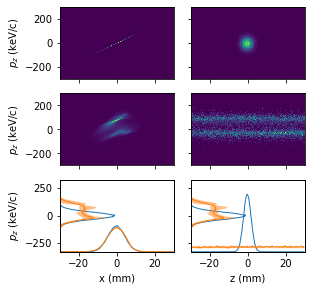

In [8]:
from visualization import add_image, add_projection, add_image_projection
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase
pairs = [["x","pz"],["z","pz"]]

fig,ax = plt.subplots(3,len(pairs), sharex="col",sharey="row")
fig.subplots_adjust(wspace=0.15, right=0.975, top=0.975)
fig.set_size_inches(4,4)
    
bins_dict = {"x":bins, "z": bins, "pz":bins*10}
#plot_bins = plot_bins * 1e3

linewidth=1.0
for i, pair in enumerate(pairs):    
    plot_bins = bins
    scale = 1e3
    
    plot_bins = [bins_dict[e] for e in pair]
    
    _, gt_image = add_image(ax[0][i], *pair, [gt_initial_beam], plot_bins,
                            scale_axis=scale)
    #print(np.max(gt_image))
    _, pred_image = add_image(ax[1][i], *pair, pred_initial_beams, plot_bins,
                           scale_axis=scale)


    # x projections
    max_dens = 250
    axa = ax[2][i].twinx()
    add_projection(axa, pair[0], [gt_initial_beam], plot_bins[0], x_scale=scale, y_scale=1)
    add_projection(axa, pair[0], pred_initial_beams, plot_bins[0], x_scale=scale, y_scale=1)
    axa.set_ylim(0,max_dens)
    axa.set_yticks([])
    
    # y projections
    axb = ax[2][i].twiny()
    add_projection(axb, pair[1], [gt_initial_beam], plot_bins[1],axis="y",x_scale=scale, y_scale=1)
    add_projection(axb, pair[1], pred_initial_beams, plot_bins[1],axis="y", x_scale=scale, y_scale=1)
    axb.set_xlim(0,max_dens/10)
    axb.set_xticks([])
    
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)

    ax[2][i].set_xlabel(pair[0] + " (mm)")


# set rasterization for pcolor
for k in range(ax.shape[-1]):
    ax[0,k].collections[0].set_rasterized(True)
    ax[1,k].collections[0].set_rasterized(True)

ax[-1,0].set_xlabel('x (mm)')
ax[-1,1].set_xlabel('z (mm)')
for a in ax[:,0]:
    a.set_ylabel("$p_z$ (keV/c)")

print(pred_initial_beams[0].z.std())
print(pred_initial_beams[0].pz.std())

# set ticks for lower x-axis
for a in ax[-1]:
    a.set_xticks([-20,0,20])
    

#fig.savefig("longitudinal_dist.svg")

In [9]:
print("Y")

def get_cov(beam):
    beam_data = beam.data
    beam_data[:,1] = beam.xp
    beam_data[:,3] = beam.yp

    return torch.cov(beam_data.T)

print(get_cov(gt_initial_beam)[2:4,2:4].det().sqrt())
pred_emit = torch.tensor([get_cov(ele)[2:4,2:4].det().sqrt() for ele in
                          pred_initial_beams])
print(pred_emit.mean())
print(pred_emit.std())

Y
tensor(1.5601e-05, dtype=torch.float64)
tensor(1.6759e-05)
tensor(1.8578e-07)


In [10]:
print("x")
print(get_cov(gt_initial_beam)[0:2,0:2].det().sqrt())
pred_emit = torch.tensor([get_cov(ele)[0:2,0:2].det().sqrt() for ele in pred_initial_beams])
print(pred_emit.mean())
print(pred_emit.std())

x
tensor(2.2289e-06, dtype=torch.float64)
tensor(2.4213e-06)
tensor(3.5590e-08)


<AxesSubplot:>

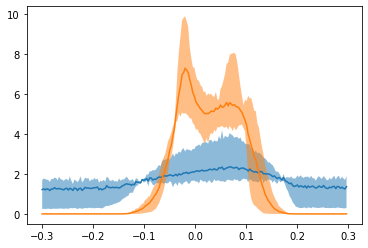

In [11]:
# plot reconstructed beam dist
from visualization import add_projection
beams = [ele.beam_generator() for ele in ensemble]

fig,ax = plt.subplots()
#add_projection(ax, "x", beams, xx[0].T[0])
#add_projection(ax, "y", beams, xx[0].T[0])
#add_projection(ax, "px", beams, xx[0].T[0])
#add_projection(ax, "py", beams, xx[0].T[0])
add_projection(ax, "z", beams, xx[0].T[0]*10)
add_projection(ax, "pz", beams, xx[0].T[0]*10)

In [12]:
# plot results from initial_ensemble
# get initial set of estimators
initial_estimators = []
for _ in range(200):
    initial_estimators.append(ensemble._make_estimator())

initial_estimators = torch.nn.ModuleList(initial_estimators)
initial_estimators.load_state_dict(torch.load("initial_ensemble.pt"))

FileNotFoundError: [Errno 2] No such file or directory: 'initial_ensemble.pt'

In [ ]:
# plot reconstructed beam dist
from visualization import add_projection
initial_beams = [ele.beam_generator() for ele in initial_estimators]

fig,ax = plt.subplots(3,1,sharex="all")
fig.set_size_inches(5,10)
add_projection(ax[0], "z", beams, xx[0].T[0], "_fit")
add_projection(ax[0], "z", initial_beams, xx[0].T[0], "_initial")

add_projection(ax[1], "pz", beams, xx[0].T[0], "_fit")
add_projection(ax[1], "pz", initial_beams, xx[0].T[0], "_initial")

add_projection(ax[2], "x", beams, xx[0].T[0], "_fit")
add_projection(ax[2], "x", initial_beams, xx[0].T[0], "_initial")

for ele in ax:
    ele.legend()
fig.savefig("entropy.png")